In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import networkx as nx
sns.set_context('poster')
mpl.rcParams['figure.figsize'] = (8,6)

1. Cargar el dataset con los datos para cada sujeto y los nombres y coordenadas de las regiones cerebrales a las que se les registró la actividad

In [2]:
RegionsNames = pd.read_csv("aal_extended_withCoords.csv", header=None).iloc[:,1:]
RegionsNames.head()

,1,2,3,4,5,6,7
0,Precentral_L,2001,Central,L,-39,-6,51
1,Precentral_R,2002,Central,R,41,-8,52
2,Frontal_Sup_L,2101,Frontal,L,-18,35,42
3,Frontal_Sup_R,2102,Frontal,R,22,31,44
4,Frontal_Sup_Orb_L,2111,Frontal,L,-17,47,-13


In [9]:
files = os.listdir('DataSujetos/')
sujetos = pd.DataFrame(files)
sujetos['estado'] = sujetos[0].apply(lambda x:x.split('_')[0])
sujetos['sujeto'] = sujetos[0].apply(lambda x:x.split('_')[1].split('.')[0])
sujetos['sujeto'] = sujetos['sujeto'].str.replace(repl='',pat='suj').astype('object')
sujetos.rename(columns={0:'path'},inplace=True)
sujetos.set_index('path',inplace=True)
sujetos.head()

,estado,sujeto
path,,
N1_suj1.csv,N1,1
N1_suj10.csv,N1,10
N1_suj11.csv,N1,11
N1_suj12.csv,N1,12
N1_suj13.csv,N1,13


2. Reportar cuántos sujetos y cuántos estados de sueño se observan en el conjunto de
datos.

In [11]:
print(sujetos.estado.value_counts().to_latex())

\begin{tabular}{lr}
\toprule
 & count \\
estado &  \\
\midrule
N1 & 18 \\
N2 & 18 \\
N3 & 18 \\
W & 18 \\
\bottomrule
\end{tabular}



3. Graficar la matriz de correlaciones entre regiones (es decir, la "matriz de adyacencia
pesada") para el sujeto 2 de la condición despierto ("Wake")

In [13]:
suj2_w = sujetos[(sujetos['sujeto']=='2')&(sujetos['estado']=='W')].index[0]
suj2_w = pd.read_csv('DataSujetos/'+suj2_w,header=None)

matAdyacPesada = suj2_w.values
n = matAdyacPesada.shape[0]
matAdyacPesada -= np.diag(np.ones(n))

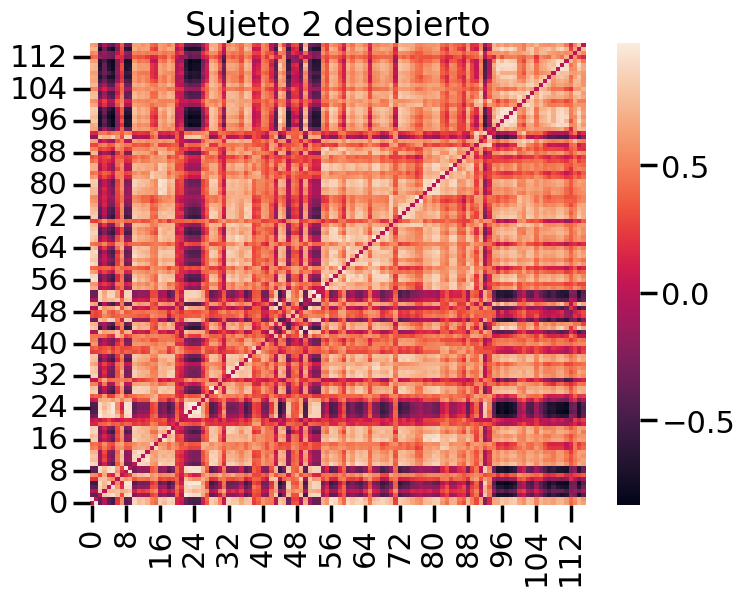

In [14]:
sns.heatmap(matAdyacPesada)
plt.xlim(0,n)
plt.ylim(0,n)
plt.title('Sujeto 2 despierto');

4. Transformar dicha matriz de adyacencia pesada a una matriz de adyancia binaria Ai,j
que represente una una densidad de enlaces δ=0.08. ¿Cuál es el valor de umbral de
correlación entre pares de regiones que tuvo que utilizar?

In [78]:
def density_to_th(W, d):
    n=W.shape[0]
    tril_idx = np.tril_indices(n,-1)
    c = sorted(np.array(list(W[tril_idx].reshape(-1))), reverse=True)
    return c[int((len(c)-1)*d)]

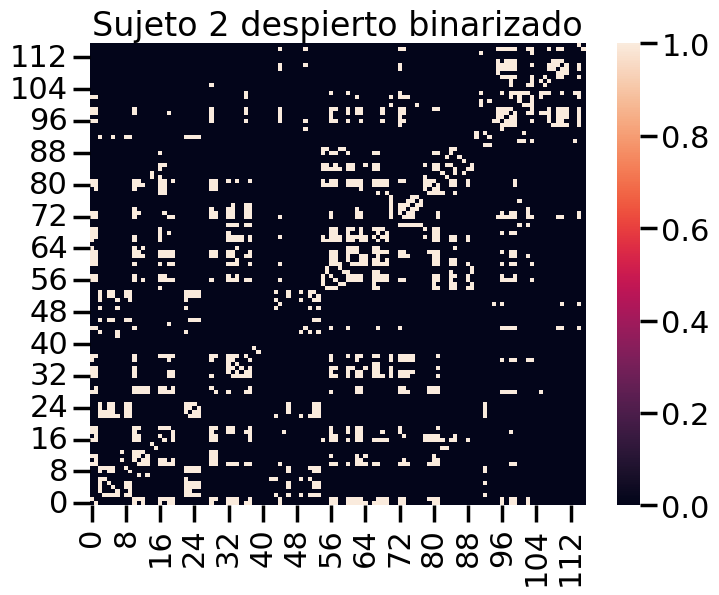

In [85]:
densidad=0.1 # comparemos ambos estados con una densidad de enlaces de 10%

thWake=density_to_th(matAdyacPesada, densidad)
matAdyacNoPesada = matAdyacPesada>=thWake

sns.heatmap(matAdyacNoPesada)
plt.xlim(0,n)
plt.ylim(0,n)
plt.title('Sujeto 2 despierto binarizado');

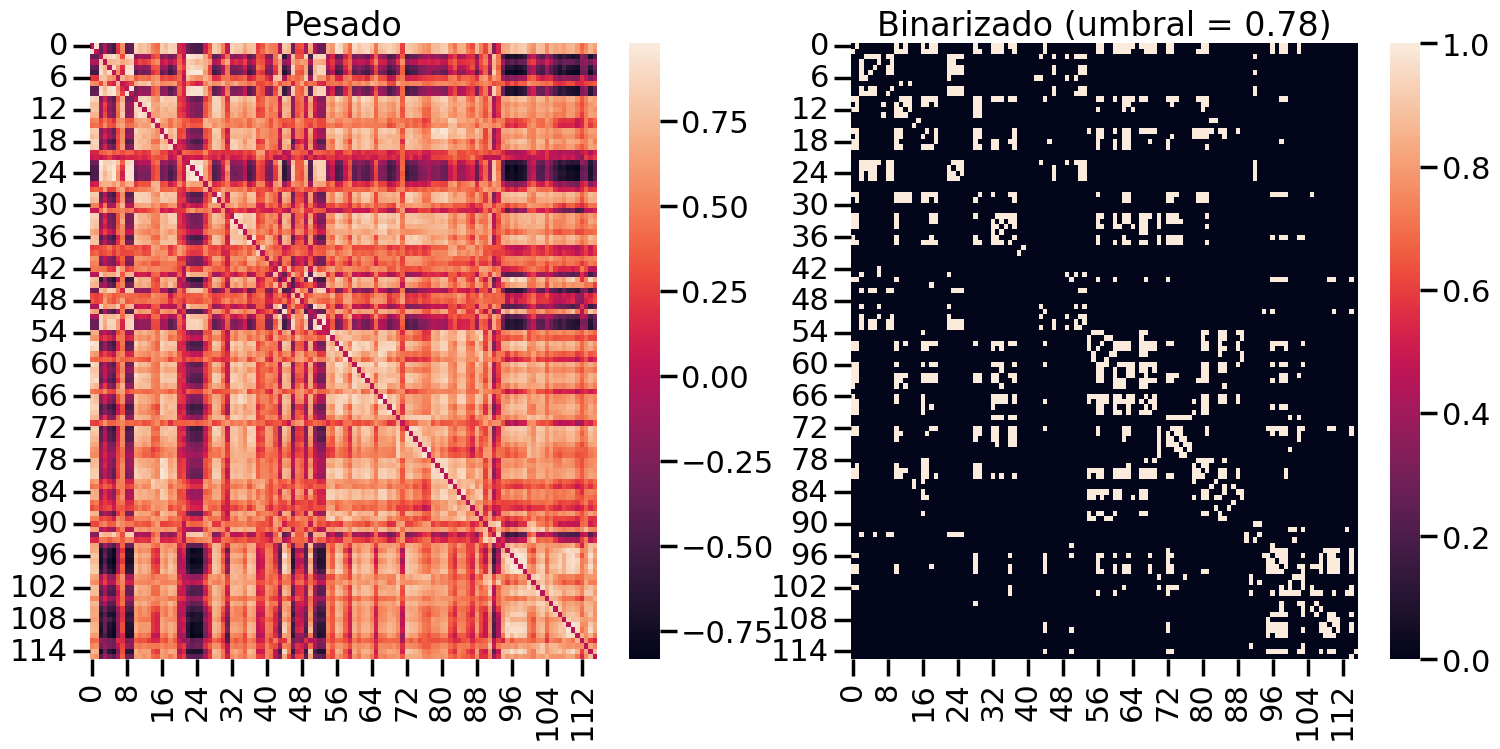

In [86]:
densidad=0.08 # comparemos ambos estados con una densidad de enlaces de 10%

thWake=density_to_th(matAdyacPesada, densidad)

# graficar los dos gráficos de arriba en uno solo
fig, axs = plt.subplots(1,2,figsize=(18,8))
sns.heatmap(matAdyacPesada,ax=axs[0])
axs[0].set_title('Pesado')
sns.heatmap(matAdyacNoPesada,ax=axs[1])
axs[1].set_title(f'Binarizado (umbral = {thWake:.2f})')
# plt.suptitle('Sujeto 2 despierto (W)');
plt.savefig('proyecto_latex/imagenes/1_Sujeto2W.png')


5. Utilizando Ai,j , obtener el grafo resultante G

In [90]:
G = nx.from_numpy_array(matAdyacNoPesada)

6. ¿Es G un grafo conectado? ¿Se puede calcular la distancia media entre pares de nodos
d del grafo G? ¿Si no se puede, qué medida equivalente calcularías?

In [91]:
#detect if graph G is connected
print(nx.is_connected(G))

#calcular la distancia media entre pares de nodos d del grafo G
distancia_media = nx.average_shortest_path_length(G)

False


NetworkXError: Graph is not connected.

7- Calcular d para cada componente conectado de G. Calcular la eﬁciencia global ef f del grafo G.

In [92]:
# obtener distancia entre cada par de nodos del grafo G
distancias = dict(nx.all_pairs_shortest_path_length(G))
distancias = pd.DataFrame(distancias)
# plt.title('Distancia entre pares de nodos')
# sns.heatmap(distancias);

#calcular la eficiencia global del grafo G
eficiencia = nx.global_efficiency(G)

8. Obtener la lista de enlaces del grafo G.

In [93]:
# obtener lista de enlaces del grafo G
enlaces = list(G.edges())
enlaces[:5]

[(0, 1), (0, 10), (0, 12), (0, 16), (0, 18)]

9. Calcular el grado promedio < k >, el nodo con grado máximo kmax, el coeﬁciente de
clustering promedio C =< Ci >

In [94]:
# calcular el grado promedio "K" del nodo G
K = np.mean([G.degree(n) for n in G.nodes()])

# calcular el nodo de mayor grado "kmax" del grafo G
kmax = np.max([G.degree(n) for n in G.nodes()])

#calcular el coeficiente de clustering promedio "C" del grafo G
C = nx.average_clustering(G)

In [95]:
print(pd.DataFrame({'Distancia media':[distancia_media],'Grado promedio (K)':[K],'Nodo con grado máximo (kmax)':[kmax],'Coeficiente de clustering promedio (C)':[C],'Eficiencia':eficiencia}).T.to_latex(index=True))

\begin{tabular}{lr}
\toprule
 & 0 \\
\midrule
Distancia media & 1.209295 \\
Grado promedio (K) & 11.500000 \\
Nodo con grado máximo (kmax) & 36.000000 \\
Coeficiente de clustering promedio (C) & 0.556270 \\
Eficiencia & 0.296510 \\
\bottomrule
\end{tabular}



10. Visualizar el grafo, ubicando los nodos en sus coordenadas cerebrales y coloreando cada nodo de acuerdo a su coeﬁciente de clustering C

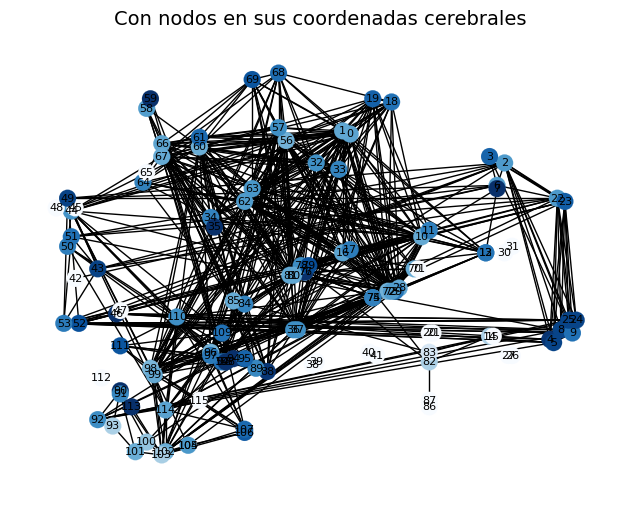

In [96]:
C = nx.clustering(G)

plt.figure(figsize=(8,6))
plt.title('Con nodos en sus coordenadas cerebrales', fontsize=14)
layout=dict(zip(range(n),np.array([RegionsNames[6].values, RegionsNames[7].values]).T))
# hacer nx.draw con el color de cada nodo según "clustering"
nx.draw(G, pos=layout, node_color=list(C.values()), with_labels=True,
        node_size=150, cmap=plt.cm.Blues,
        linewidths=.1, font_size=8)

11. Graﬁcar la distribución de grado del grafo, elijiendo un número de bins apropriado.

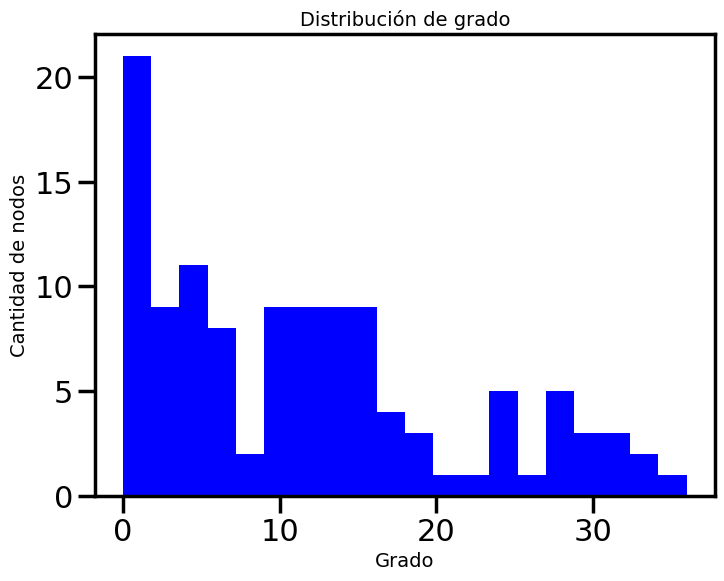

In [97]:
# Graﬁcar la distribución de grado del grafo, elijiendo un número de bins apropriado
plt.figure(figsize=(8,6))
plt.title('Distribución de grado', fontsize=14)
# hacer un histograma con el grado de cada nodo
plt.hist([G.degree(n) for n in G.nodes()], bins=20, color='b')
plt.xlabel('Grado', fontsize=14)
plt.ylabel('Cantidad de nodos', fontsize=14);

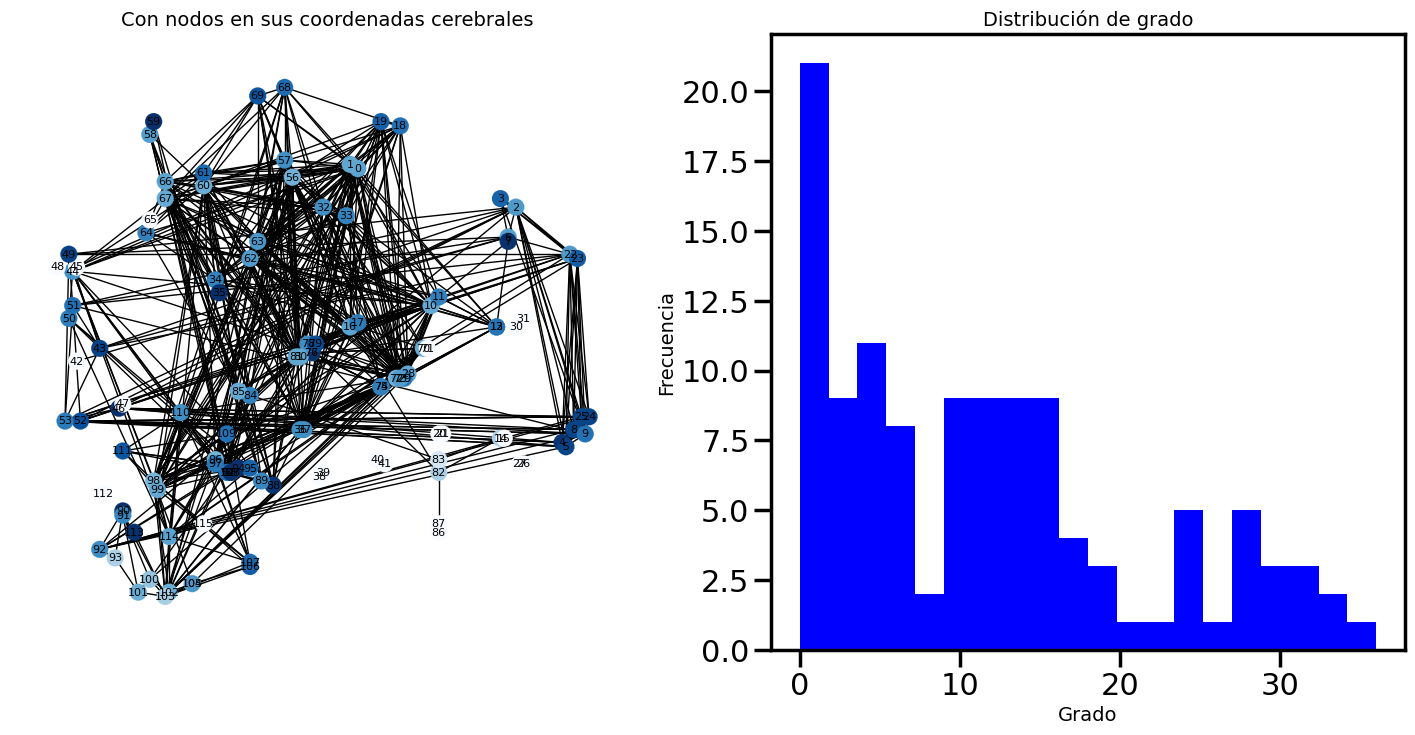

In [98]:
# combinar los dos gráficos de arriba
fig, axs = plt.subplots(1,2,figsize=(18,8))
plt.sca(axs[0])
plt.title('Con nodos en sus coordenadas cerebrales', fontsize=14)
# hacer nx.draw con el color de cada nodo según "clustering"
nx.draw(G, pos=layout, node_color=list(C.values()), with_labels=True,
        node_size=150, cmap=plt.cm.Blues,
        linewidths=.1, font_size=8)
plt.sca(axs[1])
plt.title('Distribución de grado', fontsize=14)
# hacer un histograma con el grado de cada nodo
plt.hist([G.degree(n) for n in G.nodes()], bins=20, color='b')
plt.xlabel('Grado', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
# plt.suptitle('Grafo del sujeto 2 despierto (W)');
plt.savefig('proyecto_latex/imagenes/2_Sujeto2W.png')

Vamos a comparar el grafo G con prototipos de redes poissonianas (random), small-World y scale-free, usando los algoritmos de Erdos-Renyi, Watts-Strogatz y Barabasi-Albert, respectivamente. Para ello, elegir (y reportar) los parámetros utilizados para cada algoritmo, buscando siempre que los grafos simulados de dichos prototipos sean comparables al grafo de datos G (en términos de número de nodos y números de enlaces). Visualizar un ejemplo de grafo para cada uno de estos prototipos de redes. Discutir diferencias.

In [99]:
# obtener red poissoniana explicando sus parámetros
G_poisson = nx.erdos_renyi_graph(n, K/(n-1))
# obtener red small-world
G_small_world = nx.watts_strogatz_graph(n, int(K), 0.2)
# obtener red libre de escala
G_scale_free = nx.barabasi_albert_graph(n, int(K/2))

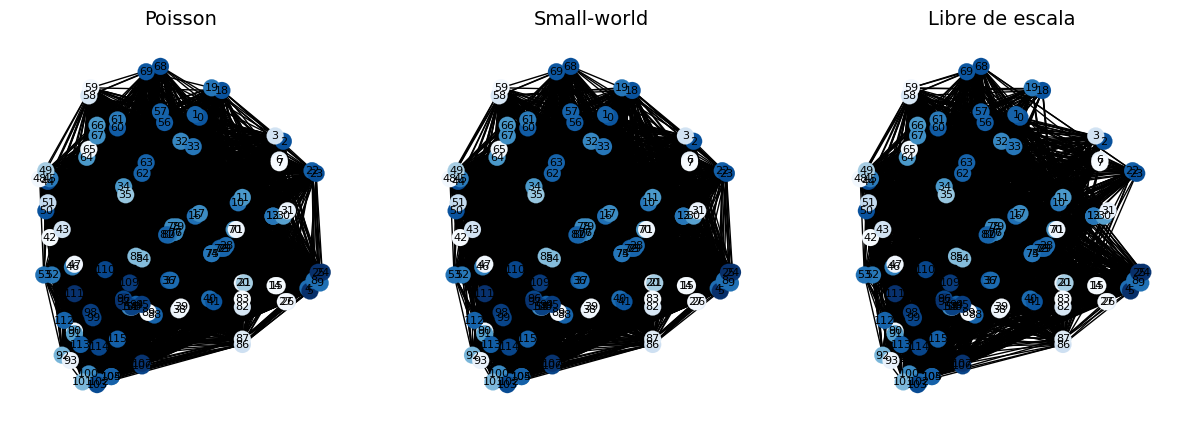

In [76]:
#graficar los tres grafos en una misma figura
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('Poisson', fontsize=14)
# hacer nx.draw con el color de cada nodo según "clustering"
nx.draw(G_poisson, pos=layout, node_color=list(C.values()), with_labels=True,
        node_size=150, cmap=plt.cm.Blues,
        linewidths=.1, font_size=8)
plt.subplot(132)
plt.title('Small-world', fontsize=14)
# hacer nx.draw con el color de cada nodo según "clustering"
nx.draw(G_small_world, pos=layout, node_color=list(C.values()), with_labels=True,
        node_size=150, cmap=plt.cm.Blues,
        linewidths=.1, font_size=8)
plt.subplot(133)
plt.title('Libre de escala', fontsize=14)
# hacer nx.draw con el color de cada nodo según "clustering"
nx.draw(G_scale_free, pos=layout, node_color=list(C.values()), with_labels=True,
        node_size=150, cmap=plt.cm.Blues,
        linewidths=.1, font_size=8)

Generar 1000 instancias de grafos para cada uno de dichos prototipos (poissonianas, small-World y scale-free). Para el conjunto de 1000 instancias de cada prototipo, calcular el histograma de coeﬁcientes de < k >, kmax, C, y ef f . Comparar con los valores de coeﬁcientes que obtuvimos para el grafo de datos G

In [77]:
# generar 1000 instancias de grafos para cada tipo de red
n_graphs = 1000
G_poisson = [nx.erdos_renyi_graph(n, K/(n-1)) for i in range(n_graphs)]
G_small_world = [nx.watts_strogatz_graph(n, int(K), 0.2) for i in range(n_graphs)]
G_scale_free = [nx.barabasi_albert_graph(n, int(K/2)) for i in range(n_graphs)]

#para el conjunto de 1000 instancias de cada red, calcular el histograma de coefiicentes de k, kmax, C
C_poisson = [nx.average_clustering(G) for G in G_poisson]
C_small_world = [nx.average_clustering(G) for G in G_small_world]
C_scale_free = [nx.average_clustering(G) for G in G_scale_free]

K_poisson = [np.mean([G.degree(n) for n in G.nodes()]) for G in G_poisson]
K_small_world = [np.mean([G.degree(n) for n in G.nodes()]) for G in G_small_world]
K_scale_free = [np.mean([G.degree(n) for n in G.nodes()]) for G in G_scale_free]

kmax_poisson = [np.max([G.degree(n) for n in G.nodes()]) for G in G_poisson]
kmax_small_world = [np.max([G.degree(n) for n in G.nodes()]) for G in G_small_world]
kmax_scale_free = [np.max([G.degree(n) for n in G.nodes()]) for G in G_scale_free]

# calcular eficiencia global para las tres redes
E_poisson = [nx.global_efficiency(G) for G in G_poisson]
E_small_world = [nx.global_efficiency(G) for G in G_small_world]
E_scale_free = [nx.global_efficiency(G) for G in G_scale_free]

In [244]:
# armar dataeframe con las metricas da cada red
df_poisson = pd.DataFrame({'red':'possion','K':K_poisson,'kmax':kmax_poisson,'C':C_poisson,'Eficiencia':E_poisson})
df_small_world = pd.DataFrame({'red':'small_world','K':K_small_world,'kmax':kmax_small_world,'C':C_small_world,'Eficiencia':E_small_world})
df_scale_free = pd.DataFrame({'red':'scale_free','K':K_scale_free,'kmax':kmax_scale_free,'C':C_scale_free,'Eficiencia':E_scale_free})

coeficientes = pd.concat((df_poisson,df_small_world,df_scale_free),axis=0)

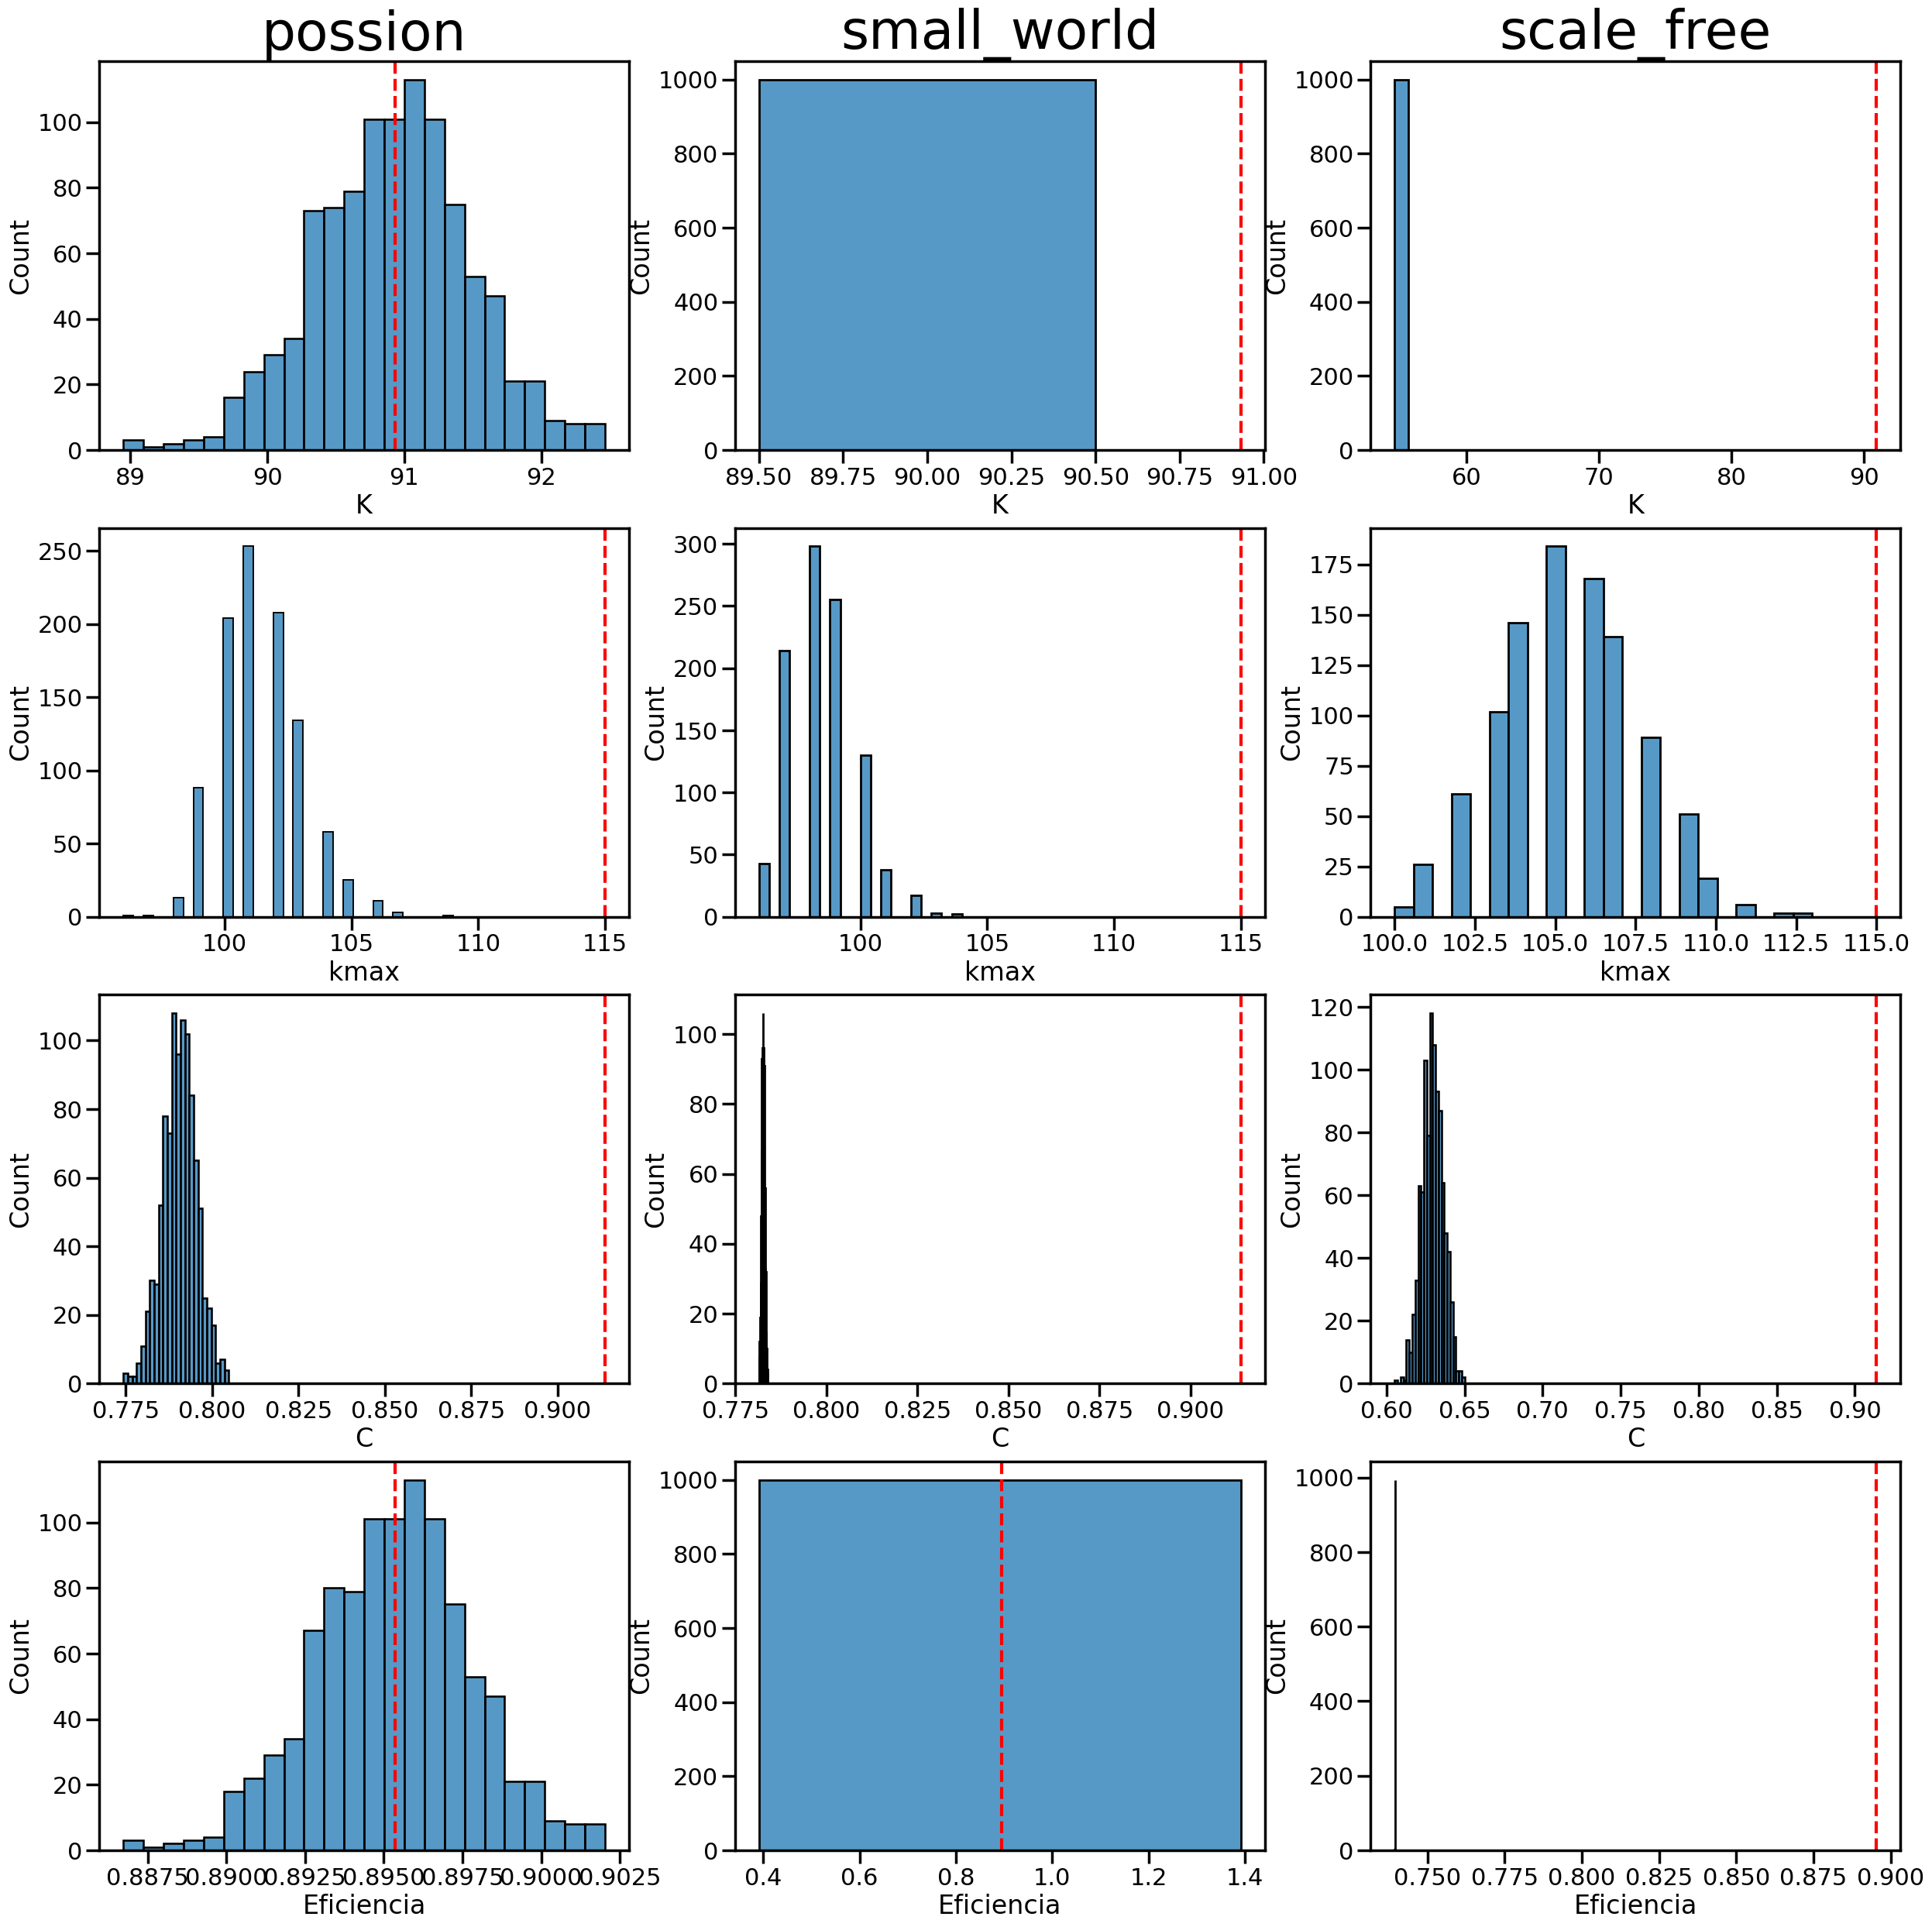

In [270]:
eficiencia_g = nx.global_efficiency(G)

metricas_g_default = pd.DataFrame({'K':[K],'kmax':[kmax],'C':[C],'Eficiencia':[eficiencia_g]})

coeficientes

#graficar histograms de cada coeficiente de cada red en un gráfico de 3X4 con seaborn
fig, ax = plt.subplots(4,3,figsize=(30,30))
for row,metrica in enumerate(['K','kmax','C','Eficiencia']):
    for column,red in enumerate(['possion','small_world','scale_free']):
        sns.histplot(coeficientes[coeficientes['red']==red][metrica],ax=ax[row,column])
        # agregar una linea vertical con el valor de metricas_g_default
        ax[row,column].axvline(metricas_g_default[metrica].values[0],color='r',linestyle='--')
        if row==0:
            ax[row,column].set_title(red,size=50)

In [259]:
metricas_g_default

,K,kmax,C,Eficiencia
0,90.931034,115,0.913744,0.895352
